# Bonus1: Parallel Algorithms

### Name: Ayman Elkfrawy


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [20]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [21]:
from sklearn.model_selection import train_test_split

split_random_state = 376

y = y.reshape(len(y), 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.16)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (645, 8)
Shape of x_test: (123, 8)
Shape of y_train: (645, 1)
Shape of y_test: (123, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [22]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.03153851  0.05243488  0.1889178   0.09972525  0.0240389   0.14461055
  -0.00672664 -0.04443469]]
test std = 
[[1.01623487 1.0023203  1.00929593 0.92622694 0.91771648 1.08975501
  0.86730217 1.03555845]]


## 1.4. Add a dimension of all ones

In [23]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (645, 9)
Shape of x_test: (123, 9)


In [24]:
VERBOSE = False

import math

class Worker:
    def __init__(self, worker_id, x, y):
        self.x = x
        self.y = y
        self.n_samples = x.shape[0]
        self.d_features = x.shape[1]
        self.w = numpy.zeros((d, 1))
        self.worker_id = worker_id
        self.log('Created')

    def log(self, message):
        if VERBOSE:
            print(f'Worker ({self.worker_id}): {message}')

    def set_params(self, w):
        self.log('Received Updated Params')
        self.w = w

    def gd_loss(self):
        self.log('Calculating GD loss')
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        loss = numpy.sum(numpy.log(1 + numpy.exp(-yxw)))
        return loss

    def sgd_loss(self):
        self.log('Calculating SGD loss')
        # yx = yi * xi # 1-by-d matrix
        # yxw = float(numpy.dot(yx, w)) # scalar
        #
        # # calculate objective function Q_i
        # loss = numpy.log(1 + numpy.exp(-yxw)) # scalar

    def gd_gradient(self): # *******
        self.log('Calculating GD gradient')
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        g_vec = numpy.divide(yx, 1 + numpy.exp(yxw))
        g = -numpy.sum(g_vec, axis=0).reshape(self.d_features, 1)
        return g


class Server:
    def __init__(self, m, n, d):
        self.m_workers = m
        self.n_samples = n
        self.d_features = d
        self.w = numpy.zeros((d, 1))
        self.g = numpy.zeros((d, 1))
        self.v = numpy.zeros((d, 1))
        self.loss = 0
        self.obj = 0
        self.log('Created')

    def log(self, message):
        if VERBOSE:
            print(f'Server: {message}')

    def broadcast(self):
        self.log('Broadcasting')
        return self.w

    def aggregate(self, grads, losses):
        self.log('Aggregating')
        self.g = numpy.zeros((self.d_features, 1))
        self.loss = 0
        for worker in range(self.m_workers):
            self.g += grads[worker]
            self.loss += losses[worker]

    def gradient(self, lam): # *****
        self.log('Calculating gradient')
        self.g = self.g / self.n_samples + lam * self.w

    def objective(self, lam): # *******
        self.log('Calculating objective fn')
        reg = lam / 2 * numpy.sum(self.w * self.w)
        self.obj = self.loss / self.n_samples + reg
        return self.obj

    def agd(self, alpha, beta):
        self.log('Calculating AGD')
        self.v *= beta
        self.v += self.g
        self.w -= alpha * self.v

    def gd(self, stepsize):
        self.log('Calculating GD')
        self.w -= stepsize * self.g


def create_server_workers(m_workers, x, y):
    n_samples, d_features = x.shape
    s = math.floor(n_samples / m_workers)
    server = Server(m_workers, n_samples, d_features)
    workers = []

    for i in range(m_workers):
        indices = list(range(i*s, (i+1) * s))
        worker = Worker('worker'+str(i), x[indices, :], y[indices, :])
        workers.append(worker)

    return server, workers

In [25]:
m_workers = 4

server, workers = create_server_workers(m_workers, x_train, y_train)

lam =  1e-6
alpha = 1e-1
beta = 0.9
max_epoch = 50
objvals = numpy.zeros(max_epoch)

for epoch in range(max_epoch):
    w = server.broadcast()
    for i in range(m_workers):
        workers[i].set_params(w)

    grads = []
    losses = []

    for i in range(m_workers):
        g = workers[i].gd_gradient()
        grads.append(g)
        l = workers[i].gd_loss()
        losses.append(l)

    server.aggregate(grads, losses)

    server.gradient(lam)
    obj = server.objective(lam)
    objvals[epoch] = obj
    print('Objective function value = ' + str(obj))
    server.agd(alpha, beta)
    # server.gd(alpha)


Objective function value = 0.6920725337683795
Objective function value = 0.6791027027936841
Objective function value = 0.6565195223912504
Objective function value = 0.628624488846037
Objective function value = 0.5995996040441474
Objective function value = 0.5726561749355987
Objective function value = 0.5496583775668435
Objective function value = 0.5312399737099203
Objective function value = 0.5171889007959767
Objective function value = 0.5068529841061638
Objective function value = 0.4994403416105239
Objective function value = 0.4941959021639337
Objective function value = 0.4904832049759473
Objective function value = 0.4878077139794748
Objective function value = 0.4858094527665584
Objective function value = 0.48424236821356154
Objective function value = 0.4829499778040401
Objective function value = 0.4818419733723135
Objective function value = 0.48087376072924476
Objective function value = 0.48002956621632975
Objective function value = 0.47930912955345717
Objective function value = 0.47

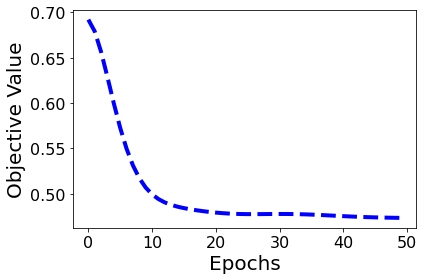

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals))
# epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals, '--b', linewidth=4)
# line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()




In [27]:
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

# evaluate training error
w = server.broadcast()
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.21550387596899226


In [28]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.21138211382113822
